# Connect

In [ ]:
# https://chat.openai.com/share/b0ec97ff-b2e8-4efb-8a07-8aa9c32a61dc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Install

In [ ]:
!pip install tqdm

In [ ]:
!pip install -q peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 11.4 MB/s eta 0:00:00


In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

In [ ]:
!pip install -q transformers accelerate

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=7e01bd31bace7d25fb7839ca46c492c7c707328a52b80b4b576d2667c3568225
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
!pip install numpy

In [ ]:
!pip install nltk>=3.4.5

In [ ]:
!pip install transformers

In [ ]:
# !pip install wandb

In [ ]:
# !wandb login '0529a3ad694a5487302b30b185aebe0c349aa1da'

# Imports

In [ ]:
import re
import nltk
import datetime,time
import pandas as pd
import string
import numpy as np
from tqdm import tqdm

from datasets import load_dataset

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import (AdamW, AutoTokenizer,AutoModelForSeq2SeqLM,
                          T5ForConditionalGeneration, T5Tokenizer,
                          AutoConfig, AutoModelForCausalLM,
                          get_linear_schedule_with_warmup)
from transformers.optimization import Adafactor, AdafactorSchedule

import random
import os

from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import get_peft_model, TaskType, prepare_model_for_int8_training

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


# Config

In [ ]:
class config:
  WANDB_KEY = '0529a3ad694a5487302b30b185aebe0c349aa1da'
  DATASET_UNLABELED_PATH1 = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/emag.json'
  DATASET_UNLABELED_PATH2 = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/decathlon_products.json'
  DATASET_UNLABELED_PATH3 = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/altex_reviews_all.json'

  DATASET_UNLABELED_PATH_FINAL = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/unlabeled_reviews_from_kg.csv'
  DATASET_LABELED_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/ro_aspects_combine_on_a_line.csv'
  DATASET_pseudoLABELED_PATH_FINAL = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/pseudolabeled_reviews.csv'

  MODEL_ATE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/models/ate_enroaug_cat_v6.pt'
  PRE_TRAINED_TOKENIZER_NAME ='google/flan-t5-large'
  MODEL_BASE ='google/flan-t5-small'

  PROMPT = 'Extract a list with the aspect terms spans of text from the following Romanian text: '  # aspect terms/categories

  MAX_SOURCE_LEN = 256
  MAX_TARGET_LEN = 32

  BATCH_SIZE_TRAIN_LBL = 2
  BATCH_SIZE_TRAIN_ULBL = 4

  BATCH_SIZE_TEST = 2

  EPOCHS=3
  LR = [1e-4, 3e-4]
  EPS = 1e-8

  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Read data

AIM: LEARN THE MODEL TO PREDICT ALL ASPECT CATEGORIES FROM A TEXT

In [ ]:
df_labeled = pd.read_csv(config.DATASET_LABELED_PATH)
df_pseudolabeled =  pd.read_csv(config.DATASET_pseudoLABELED_PATH_FINAL)

In [ ]:
# df_unlabeled1 = pd.read_json(config.DATASET_UNLABELED_PATH1)
# df_unlabeled2 = pd.read_json(config.DATASET_UNLABELED_PATH2)
# df_unlabeled3 = pd.read_json(config.DATASET_UNLABELED_PATH3)

In [ ]:
# df_unlabeled1 = df_unlabeled1[['text','most_inner_category','rating']]
# df_unlabeled2 = df_unlabeled2[['text','most_inner_category','rating']]
# df_unlabeled3 = df_unlabeled3[['text','most_inner_category','rating']]

In [ ]:
# df_unlabeled = pd.concat([df_unlabeled1, df_unlabeled2, df_unlabeled3],ignore_index=True)

In [ ]:
df_labeled.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
df_pseudolabeled.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)

In [ ]:
df_pseudolabeled.rename(columns={'pseudo_all_categories':'all_categories'}, inplace=True)

In [ ]:
df_labeled.rename(columns={'text_review':'text'}, inplace=True)

In [ ]:
df_labeled['type'] = 'labeled'
df_pseudolabeled['type'] = 'paseudo-labeled'

In [ ]:
df_labeled.head(2)

,id,text,aspect,polarity_aspect,category_aspect,all_aspects,all_categories,type
0,a.3zUCvkq5sMQniYGQsF1S7cuIRq-2979133___rating_...,Sunt foarte multumita de acest magazin.ma bucu...,Sunt foarte multumita de acest magazin,1.0,magazin,Sunt foarte multumita de acest magazin; recoma...,magazin; magazin;,labeled
1,a.5alY9PXqYHzjyhNs52eP9iiv2e-4156629___rating_...,Magazinul ok dar deranjatnti sunt copii scapat...,Magazinul ok,1.0,magazin,Magazinul ok; deranjatnti sunt copii scapati d...,magazin; atmosfera;,labeled


In [ ]:
df_pseudolabeled.head(2)

,text,most_inner_category,rating,all_categories,type
0,"Castile astea le am de la final de 2021, deci ...",GamingHeadset,4,experienta;calitate,paseudo-labeled
1,Le-am luat resigilate la appx jumătate de preț...,GamingHeadset,5,pret;calitate-calitate,paseudo-labeled


In [ ]:
# df_unlabeled.to_csv(config.DATASET_UNLABELED_PATH_FINAL)

In [ ]:
df_labeled.dropna(subset=['text'],inplace=True)
df_pseudolabeled.dropna(subset=['text'],inplace=True)
len(df_pseudolabeled), len(df_labeled)

(15943, 999)

# Utils methods

https://colab.research.google.com/drive/110SZGBXDNT9OpL_T-DddHfy1E6tYHGh3#scrollTo=wRIk4iZOkSp0

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def clean_df(df, text_col_name):
    df[text_col_name] = df[text_col_name].apply(lambda x: x.lower())
    df[text_col_name] = df[text_col_name].apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', x))
    df[text_col_name] = df[text_col_name].apply(lambda x: re.sub(r'(http|https|www)\S+', ' HTTPURL ', x))
    df[text_col_name] = df[text_col_name].apply(lambda x: " ".join(x.split()))
    df[text_col_name] =  config.PROMPT + df[text_col_name] + ' </s>'
    return df

In [ ]:
import string
punctuation = string.punctuation
punctuation = re.sub('-','',punctuation)
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_predictions(pred):
    stop_words = ['the','i','a','or',')','un','o',' ']
    # print(pred)
    pred = pred.split(';')
    pred_new = []
    for x in pred:
      if x!= ' ':
        tokens = word_tokenize(x)
        tokens = [t for t in tokens if t.lower() not in stop_words]
        tokens = ' '.join(tokens)
        tokens = re.sub(r'\)',' ', tokens)
        tokens = re.sub(r'\(',' ', tokens)
        tokens = re.sub(' +', ' ', tokens)
        tokens = tokens.translate(str.maketrans('', '', punctuation))
        tokens = tokens.strip()
        if tokens != ' ':
          pred_new.append(tokens.strip())
    return pred_new

In [ ]:
from sklearn.metrics import f1_score
def f1(pred, target):
  return f1_score(target, pred, average='weighted')

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Dataset Utils

In [ ]:
class ATEDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        text = item['text']
        target = item['all_categories']
        was_labeled = True
        if item['type']=='pseudo-labeled':
          was_labeled=False
        return {
            'text': text,
            'target': target,
            'was_labeled':was_labeled,
            'source_inputs_ids' : torch.tensor(item['source_inputs_ids']).squeeze().to(config.DEVICE, dtype=torch.long),
            'source_attention_mask' : torch.tensor(item['source_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),
        }


In [ ]:
def tokenize_function(text, tokenizer, max_len):
  encoded_dict = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )
  return encoded_dict['input_ids'].squeeze(), encoded_dict['attention_mask'].squeeze()

In [ ]:
def tokenize_batch(tokenizer,batch, max_len):
  encoded_dict = tokenizer.batch_encode_plus(
              batch,
              add_special_tokens=True,
              max_length=max_len,
              truncation=True,
              padding='max_length',
              return_attention_mask=True,
              return_tensors='pt'
          )
  return encoded_dict['input_ids'].squeeze(), encoded_dict['attention_mask'].squeeze()

# Target based student teacher framework

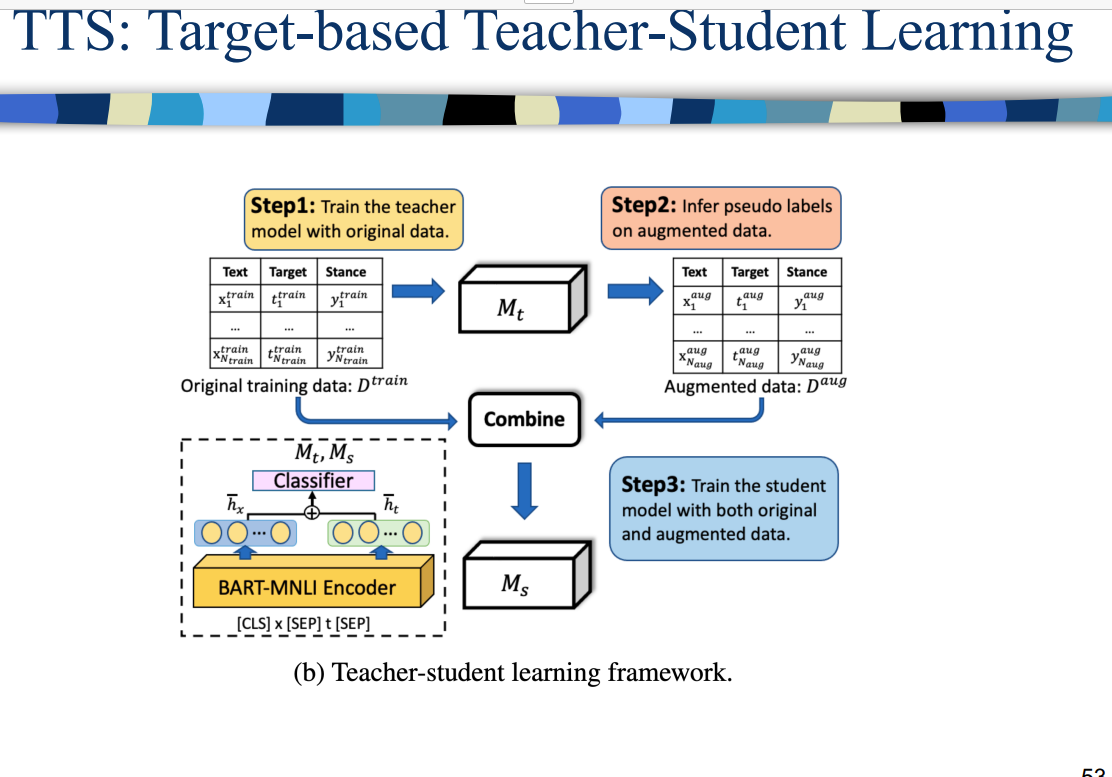



#1 Assign pseudo-labels on unlabeled data with the teacher model

In [ ]:
# tokenizer_flan = AutoTokenizer.from_pretrained(config.PRE_TRAINED_TOKENIZER_NAME)
# model_teacher = T5ForConditionalGeneration.from_pretrained(config.MODEL_ATE_PATH)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# model_teacher = model_teacher.to(config.DEVICE)

In [ ]:
# df_pseudolabeled_cut = df_pseudolabeled[(df_pseudolabeled['text_len']<256) & (df_pseudolabeled['text_len']>20)]
# print(len(df_pseudolabeled_cut), len(df_labeled))
# df_pseudolabeled_cut = df_pseudolabeled_cut[:8*len(df_labeled)]
# print(len(df_pseudolabeled_cut), len(df_labeled)*8)

(5828, 719)

In [ ]:
# df_pseudolabeled_cut['source_inputs_ids'], df_pseudolabeled_cut['source_attention_mask'] = zip(* df_pseudolabeled_cut.apply(lambda x: tokenize_function(x['text'],
#                                                                                                                                 tokenizer_flan,
#                                                                                                                                 config.MAX_SOURCE_LEN),
#                                                                                                                                 axis=1))

In [ ]:
# df_labeled['source_inputs_ids'], df_labeled['source_attention_mask'] = zip(* df_labeled.apply(lambda x: tokenize_function(x['text'],
#                                                                                               tokenizer_flan,
#                                                                                               config.MAX_SOURCE_LEN),
#                                                                                               axis=1))

In [ ]:
# ds_pseudolabeled_cut = ATEDataset(df_pseudolabeled_cut)
# ds_labeled = ATEDataset(df_labeled)

In [ ]:
# dataloader_pseudolabeled_cut = DataLoader(ds_pseudolabeled_cut, batch_size=config.BATCH_SIZE_TRAIN_ULBL, shuffle=False)
# dataloader_labeled = DataLoader(ds_labeled, batch_size=config.BATCH_SIZE, shuffle=False)

## Infer with generate - first pseudo-labels

In [ ]:
def infer_with_generate(model, tokenizer, dataloader):
  model.eval()
  print("Running Inference ...")
  predictions = []

  for batch in dataloader:
      source_input_ids = batch['source_inputs_ids']
      source_attention_mask = batch['source_attention_mask']
      text = batch['text']

      with torch.no_grad():
          generated_ids = model.generate(
                    input_ids=source_input_ids,
                    attention_mask=source_attention_mask,
                    temperature=0.2,
                    use_cache=True,
                    penalty_alpha=2.5,
                    num_beams=5,
                    do_sample=True,
                    no_repeat_ngram_size=1,
                    num_return_sequences=1,
                    early_stopping=True,
                    max_length=config.MAX_TARGET_LEN
                    )

      preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
      preds_cleaned = [clean_predictions(p) for p in preds]
      print('Cleaned predictions:',preds_cleaned)

      current_pairs = zip(text, preds_cleaned)
      predictions.extend(current_pairs)
  return predictions

## First generation for unlabeled dataset

In [ ]:
predictions_paired = infer_with_generate(model_teacher, tokenizer_flan, dataloader_unlabeled)

Running Inference ...


<ipython-input-28-30c5f826526d>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'source_inputs_ids' : torch.tensor(item['source_inputs_ids']).squeeze().to(config.DEVICE, dtype=torch.long),
<ipython-input-28-30c5f826526d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'source_attention_mask' : torch.tensor(item['source_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),


Streaming output truncated to the last 5000 lines.
servicii; calitate-calitate
pret-calitate; utilizare
pret; 
pret-calitate; produs
Cleaned predictions: [['servicii', 'calitate-calitate'], ['pret-calitate', 'utilizare'], ['pret'], ['pret-calitate', 'produs']]
servicii; personal-calitate 
magazin; personal-calitate
pret; calitate 
produs; disponibilitate
Cleaned predictions: [['servicii', 'personal-calitate'], ['magazin', 'personal-calitate'], ['pret', 'calitate'], ['produs', 'disponibilitate']]
produs; pret-calitate 
varietate; 
aprovizionare; utilizare
produs; utilizare-calitate 
Cleaned predictions: [['produs', 'pret-calitate'], ['varietate'], ['aprovizionare', 'utilizare'], ['produs', 'utilizare-calitate']]
marimi; 
calitate; 
produs; utilizare-calitate 
experienta; organizare 
Cleaned predictions: [['marimi'], ['calitate'], ['produs', 'utilizare-calitate'], ['experienta', 'organizare']]
comanda; 
produs; personal-calitate 
produs; comanda-calitate 
conformitate; 
Cleaned predictio

In [ ]:
predictions_paired[1]

('Le-am luat resigilate la appx jumătate de preț si sunt bune. Se aude un țiuit continuu dar este acoperit daca asculți ceva. Recomand.',
 ['pret', 'calitate-calitate'])

In [ ]:
predictions_df = pd.DataFrame(predictions_paired, columns=['text','category'])

In [ ]:
predictions_df

,text,category
0,"Castile astea le am de la final de 2021, deci ...","[experienta, calitate]"
1,Le-am luat resigilate la appx jumătate de preț...,"[pret, calitate-calitate]"
2,Vad ca sunt foarte multe reviewuri pozitive da...,"[irelevant, personal-calitate]"
3,La inceput aveau probleme software. Se auzeau ...,"[personal, servicii asamblare]"
4,"Castile au o flexibilitate mare, se simte cali...","[experienta, calitate-calitate]"
...,...,...
18671,L-am cumparat din magazinul Altex sin Ploieşti...,"[produs, dimensiuni]"
18672,"Este SUPER! Super stabil, robust, se poate tra...","[produs, utilizare-calitate]"
18673,Sistemul de prindere a camerei e foarte fain c...,"[organizare, produs-calitate]"
18674,Cam scump dar isi merita bani. L-am prins la r...,"[pret, produs]"


In [ ]:
assert len(df_unlabeled)==len(predictions_paired)

In [ ]:
df_unlabeled.head(2)

,text,most_inner_category,rating,source_inputs_ids,source_attention_mask,all_categories
0,"Castile astea le am de la final de 2021, deci ...",GamingHeadset,4,"[[tensor(11583), tensor(699), tensor(22237), t...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",
1,Le-am luat resigilate la appx jumătate de preț...,GamingHeadset,5,"[[tensor(312), tensor(18), tensor(265), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",


In [ ]:
df_unlabeled['all_categories']=''

In [ ]:
def map_label(row):
  row_map = predictions_df[predictions_df['text']==row['text']].iloc[0]
  label = ';'.join(row_map['category'])
  return label

In [ ]:
df_unlabeled['pseudo_all_categories'] = df_unlabeled.apply(lambda x: map_label(x),axis=1)

In [ ]:
df_unlabeled.drop(columns=['all_categories'], inplace=True)

In [ ]:
df_unlabeled.drop_duplicates(subset=["text"], inplace=True)

In [ ]:
df_unlabeled

,text,most_inner_category,rating,source_inputs_ids,source_attention_mask,pseudo_all_categories
0,"Castile astea le am de la final de 2021, deci ...",GamingHeadset,4,"[[tensor(11583), tensor(699), tensor(22237), t...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",experienta;calitate
1,Le-am luat resigilate la appx jumătate de preț...,GamingHeadset,5,"[[tensor(312), tensor(18), tensor(265), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",pret;calitate-calitate
2,Vad ca sunt foarte multe reviewuri pozitive da...,GamingHeadset,3,"[[tensor(2964), tensor(26), tensor(212), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",irelevant;personal-calitate
3,La inceput aveau probleme software. Se auzeau ...,GamingHeadset,4,"[[tensor(325), tensor(9985), tensor(3), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",personal;servicii asamblare
4,"Castile au o flexibilitate mare, se simte cali...",GamingHeadset,5,"[[tensor(11583), tensor(699), tensor(185), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",experienta;calitate-calitate
...,...,...,...,...,...,...
18671,L-am cumparat din magazinul Altex sin Ploieşti...,Tripod,5,"[[tensor(301), tensor(18), tensor(265), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",produs;dimensiuni
18672,"Este SUPER! Super stabil, robust, se poate tra...",Tripod,5,"[[tensor(2972), tensor(29640), tensor(55), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",produs;utilizare-calitate
18673,Sistemul de prindere a camerei e foarte fain c...,Tripod,4,"[[tensor(3), tensor(28327), tensor(20), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",organizare;produs-calitate
18674,Cam scump dar isi merita bani. L-am prins la r...,Tripod,1,"[[tensor(5184), tensor(23287), tensor(649), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",pret;produs


In [ ]:
df_unlabeled.to_csv(config.DATASET_pseudoLABELED_PATH_FINAL)

# Train a student model un the pseudo-labeled + labeled data

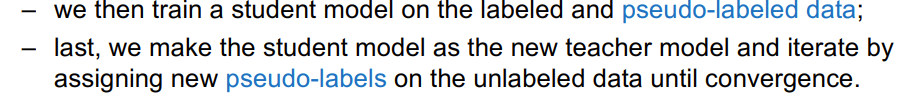

In [ ]:
tokenizer_flan = AutoTokenizer.from_pretrained(config.PRE_TRAINED_TOKENIZER_NAME)
# model_teacher = T5ForConditionalGeneration.from_pretrained(config.MODEL_ATE_PATH)
# model_teacher.to(config.DEVICE)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

## data prep

In [ ]:
from sklearn.model_selection import train_test_split

df_labeled = df_labeled[:200]
df_labeled, df_test = train_test_split(df_labeled,test_size=0.2,random_state=42)
df_labeled, df_val = train_test_split(df_labeled,test_size=0.1, random_state=42)

In [ ]:
df_pseudolabeled = df_pseudolabeled[:200]
lengths = [len(tokenizer_flan.encode(text)) for text in list(df_pseudolabeled['text'].values)]
df_pseudolabeled['text_len']=lengths

df_pseudolabeled_cut = df_pseudolabeled[df_pseudolabeled['text_len']<256]
len(df_pseudolabeled_cut), len(df_labeled)

Token indices sequence length is longer than the specified maximum sequence length for this model (617 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-38-51911c0d7f63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pseudolabeled['text_len']=lengths


(188, 144)

In [ ]:
df_pseudolabeled_cut = df_pseudolabeled_cut[:144]

In [ ]:
len(df_labeled), len(df_val), len(df_test), len(df_pseudolabeled_cut)

(144, 16, 40, 144)

In [ ]:
df_pseudolabeled_cut = clean_df(df_pseudolabeled_cut,'text')
df_labeled = clean_df(df_labeled,'text')
df_val = clean_df(df_val,'text')
df_test = clean_df(df_test,'text')

In [ ]:
df_pseudolabeled_cut['text'].iloc[0]

'Extract a list with the aspect terms spans of text from the following Romanian text: le-am luat resigilate la appx jumătate de preț si sunt bune. se aude un țiuit continuu dar este acoperit daca asculți ceva. recomand. </s>'

In [ ]:
df_pseudolabeled_cut['source_inputs_ids'], df_pseudolabeled_cut['source_attention_mask'] = zip(* df_pseudolabeled_cut.apply(lambda x: tokenize_function(x['text'],
                                                                                                                                tokenizer_flan,
                                                                                                                                config.MAX_SOURCE_LEN),
                                                                                                                                axis=1))

df_labeled['source_inputs_ids'], df_labeled['source_attention_mask'] = zip(* df_labeled.apply(lambda x: tokenize_function(x['text'],
                                                                                                                                tokenizer_flan,
                                                                                                                                config.MAX_SOURCE_LEN),
                                                                                                                                axis=1))

In [ ]:
# df_val['source_inputs_ids'], df_val['source_attention_mask'] = zip(* df_val.apply(lambda x: tokenize_function(x['text'],
#                                                                                                               tokenizer_flan,
#                                                                                                               config.MAX_SOURCE_LEN),
#                                                                                                               axis=1))
# df_test['source_inputs_ids'], df_test['source_attention_mask'] = zip(* df_test.apply(lambda x: tokenize_function(x['text'],
#                                                                                                               tokenizer_flan,
#                                                                                                               config.MAX_SOURCE_LEN),
#                                                                                                               axis=1))


## dataset and dataloder

In [ ]:
# ds_test = ATEDataset(df_test)
# ds_val = ATEDataset(df_val)

# test_dataloader = DataLoader(ds_test, batch_size=config.BATCH_SIZE_TEST, shuffle=False)
# val_dataloader = DataLoader(ds_val, batch_size=config.BATCH_SIZE_TEST, shuffle=False)

In [ ]:
ds_pseudolabeled_cut = ATEDataset(df_pseudolabeled_cut)
ds_labeled = ATEDataset(df_labeled)

train_dataloader_cut_ulbl = DataLoader(ds_pseudolabeled_cut, batch_size=config.BATCH_SIZE_TRAIN_ULBL, shuffle=False)
train_dataloader_lbl = DataLoader(ds_labeled, batch_size=config.BATCH_SIZE_TRAIN_LBL, shuffle=False)

## hyperparam functions

In [ ]:
def initialize_parameters(model, train_dataloader, optimizer_name, idx_lr):
  total_steps = len(train_dataloader) * config.EPOCHS

  if optimizer_name=='adam':
    optimizer = AdamW(model.parameters(), lr=config.LR[idx_lr], eps=config.EPS, correct_bias=False, no_deprecation_warning=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  elif optimizer_name=='ada':
    # optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=config.LEARNING_RATE[idx_lr], clip_threshold=1.0)  # noqa: E501
    optimizer = Adafactor(model.parameters(), relative_step=True, warmup_init=True, lr=None, clip_threshold=1.0)  # noqa: E501
    scheduler = AdafactorSchedule(optimizer)

  autoconfig = AutoConfig.from_pretrained(config.MODEL_BASE)
  return optimizer, scheduler, autoconfig


In [ ]:
import torch
import torch.nn as nn

criterion_lbl = nn.CrossEntropyLoss(ignore_index=-100, reduction='mean')
criterion_ulbl = nn.CrossEntropyLoss(ignore_index=-100, reduction='none')

## Utils functions


To implement a confidence threshold for the T5 model's predictions, you need to calculate the confidence of the model in its output. In the case of T5 and similar sequence-to-sequence models, this is not as straightforward as models that output a single class with a probability distribution, because the output is a sequence of tokens.

We can  measure the difference between the log probabilities of the generated tokens and the log probabilities of the ground truth tokens. This comparison can provide insights into how well the model's predictions align with the actual (ground truth) data. This difference is essentially a measure of the model's prediction error in terms of probability.

In [ ]:
def calculate_confidence_logprob_diff(model, input_ids, generated_tokens, ground_truth_tokens):
    # Pass the input through the model
    outputs = model(input_ids=input_ids, labels=ground_truth_tokens)

    # Compute log probabilities
    log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)

    # Gather log probabilities for generated and ground truth tokens
    gen_log_probs = log_probs.gather(2, generated_tokens.unsqueeze(-1)).squeeze(-1)
    gt_log_probs = log_probs.gather(2, ground_truth_tokens.unsqueeze(-1)).squeeze(-1)

    # Calculate the difference and return its absolute value
    diff = (gen_log_probs - gt_log_probs).abs().mean()
    return diff.item()


In [ ]:
def calculate_confidence_average(tokenizer, outputs, model_output):
  log_probs = torch.nn.functional.log_softmax(model_output.logits, dim=-1)
  token_confidences = log_probs.gather(2, outputs.unsqueeze(-1)).squeeze(-1)
  mask = (outputs != tokenizer.pad_token_id) & (outputs != tokenizer.eos_token_id) & (outputs != tokenizer.bos_token_id)
  masked_confidences = token_confidences * mask
  avg_confidence = masked_confidences.sum(dim=1) / mask.sum(dim=1)
  return avg_confidence

In [ ]:
def generate_pseudo_labels_with_confidence(teacher_model, unlabeled_df, tokenizer, confidence_threshold):
  teacher_model.eval()
  pseudo_labels = []

  for idx, row in unlabeled_df.iterrow():
    input_ids, _ = tokenize_function(row['text'],tokenizer,config.MAX_SOURCE_LEN)
    input_ids = input_ids.to(config.DEVICE)

    with torch.no_grad():
      out = teacher_model(input_ids=input_ids, decoder_input_ids=input_ids)
      outputs = teacher_model.generate(input_ids)

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    confidence = calculate_confidence_average(outputs, out).item()
    if confidence >= confidence_threshold:
      pseudo_labels.append((row['text'], prediction))

  return pseudo_labels

In [ ]:
def generate_pseudo_labels_with_log_prob_diff(teacher_model, unlabeled_data, tokenizer, threshold):
    teacher_model.eval()
    pseudo_labels = []

    for text in unlabeled_data:
        input_ids = tokenizer.encode("extract aspects: " + text, return_tensors="pt")
        with torch.no_grad():
            generated_outputs = teacher_model.generate(input_ids)
        generated_tokens = generated_outputs[0]

        # Assume you have a function to get ground truth tokens for the text
        ground_truth_tokens = get_ground_truth_tokens_for(text)

        # Calculate the log probability difference
        log_prob_diff = calculate_confidence_logprob_diff(teacher_model, input_ids, generated_tokens, ground_truth_tokens)

        if log_prob_diff < threshold:
            prediction = tokenizer.decode(generated_tokens, skip_special_tokens=True)
            pseudo_labels.append((text, prediction))

    return pseudo_labels


## train loop

In [ ]:
model_student = T5ForConditionalGeneration.from_pretrained(config.MODEL_BASE)
model_student = model_student.to(config.DEVICE)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
optimizer, scheduler, autoconfig = initialize_parameters(model_student, train_dataloader_cut_ulbl, 'adam',0)

In [ ]:
def train_one_epoch(model_student, dataloader_lbl, dataloader_ulbl, optimizer, epoch, loss_weight):
    total_t0 = time.time()
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, config.EPOCHS))
    print('Training...')

    train_total_loss = 0
    model_student.train()

    for step, (batch_lbl, batch_ulbl) in tqdm(enumerate(zip(dataloader_lbl, dataloader_ulbl))):

        if step % 40 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader_ulbl)))

        source_input_ids_lbl = batch_lbl['source_inputs_ids'].to(config.DEVICE)
        source_attention_mask_lbl = batch_lbl['source_attention_mask'].to(config.DEVICE)
        lm_labels_lbl, _ = tokenize_batch( tokenizer_flan, batch_lbl['target'], config.MAX_TARGET_LEN)

        source_input_ids_ulbl = batch_ulbl['source_inputs_ids'].to(config.DEVICE)
        source_attention_mask_ulbl = batch_ulbl['source_attention_mask'].to(config.DEVICE)
        lm_labels_ulbl, _ = tokenize_batch( tokenizer_flan, batch_ulbl['target'], config.MAX_TARGET_LEN)

        lm_labels_lbl[lm_labels_lbl == tokenizer_flan.pad_token_id] = -100
        lm_labels_ulbl[lm_labels_ulbl == tokenizer_flan.pad_token_id] = -100

        lm_labels_lbl.to(config.DEVICE)
        lm_labels_ulbl.to(config.DEVICE)

        optimizer.zero_grad()

        out_ulbl = model_student(input_ids=source_input_ids_ulbl,
                                          attention_mask=source_attention_mask_ulbl,
                                          labels=lm_labels_ulbl)

        out_lbl = model_student(input_ids=source_input_ids_lbl,
                                        attention_mask=source_attention_mask_lbl,
                                        labels=lm_labels_lbl)

        loss_sup = criterion_lbl(out_lbl.logits.view(-1, out_lbl.logits.size(-1)), lm_labels_lbl.view(-1))
        loss_unsup = criterion_ulbl(out_ulbl.logits.view(-1, out_ulbl.logits.size(-1)), lm_labels_ulbl.view(-1))

        loss_agg = (1-loss_weight) * loss_sup + loss_weight * torch.mean(loss_unsup)
        train_total_loss += loss_agg.item()

        loss_agg.backward()

        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model_student.parameters(), 1.0)

    avg_train_loss = train_total_loss / len(dataloader_ulbl)

    training_time = format_time(time.time() - total_t0)

    print("")
    print("summary results")
    print("epoch | trn loss | trn time ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {training_time:}")
    return avg_train_loss


## Test how can I get the logits form the model

In [ ]:
train_total_loss = 0
model_student.train()

for step, (batch_lbl, batch_ulbl) in tqdm(enumerate(zip(train_dataloader_lbl, train_dataloader_cut_ulbl))):

    if step % 40 == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader_cut_ulbl)))

    source_input_ids_lbl = batch_lbl['source_inputs_ids'].to(config.DEVICE)
    source_attention_mask_lbl = batch_lbl['source_attention_mask'].to(config.DEVICE)
    target_lbl = batch_lbl['target']

    lm_labels_lbl, _ = tokenize_batch( tokenizer_flan, target_lbl, config.MAX_TARGET_LEN)
    lm_labels_lbl=lm_labels_lbl.to(config.DEVICE)

    source_input_ids_ulbl = batch_ulbl['source_inputs_ids'].to(config.DEVICE)
    source_attention_mask_ulbl = batch_ulbl['source_attention_mask'].to(config.DEVICE)
    target_ulbl = batch_ulbl['target']

    lm_labels_ulbl, _ = tokenize_batch(tokenizer_flan, target_ulbl,config.MAX_TARGET_LEN)
    lm_labels_ulbl=lm_labels_ulbl.to(config.DEVICE)

    optimizer.zero_grad()


    out_ulbl = model_student(input_ids=source_input_ids_ulbl,
                              attention_mask=source_attention_mask_ulbl,
                              labels=lm_labels_ulbl)

    out_lbl = model_student(input_ids=source_input_ids_lbl,
                            attention_mask=source_attention_mask_lbl,
                            labels=lm_labels_lbl)

    loss_sup = criterion_lbl(out_lbl.logits.view(-1, out_lbl.logits.size(-1)), lm_labels_lbl.view(-1))
    loss_unsup = criterion_ulbl(out_ulbl.logits.view(-1, out_ulbl.logits.size(-1)), lm_labels_ulbl.view(-1))

    loss_agg = 0.5 * loss_sup + 0.5 * torch.mean(loss_unsup)
    train_total_loss += loss_agg.item()
    print(train_total_loss)

    loss_agg.backward()
    print(loss_agg)
    break


0it [00:00, ?it/s]<ipython-input-34-57c71c7cb545>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'source_inputs_ids' : torch.tensor(item['source_inputs_ids']).squeeze().to(config.DEVICE, dtype=torch.long),
<ipython-input-34-57c71c7cb545>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'source_attention_mask' : torch.tensor(item['source_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),


30.21454620361328


0it [00:02, ?it/s]

tensor(30.2145, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
len(train_dataloader_lbl)

(72, 72)

In [ ]:
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [ ]:
dataloader_unlabeled = DataLoader(ds_unlabeled_logits, batch_size=config.BATCH_SIZE, shuffle=False)
dataloader_labeled = DataLoader(ds_labeled_logits, batch_size=config.BATCH_SIZE, shuffle=False)

In [ ]:
import torch.nn.functional as F

In [ ]:
model_teacher.eval()
print("Running Inference ...")
predictions = []

for batch_lbl, batch_ulbl in zip(dataloader_labeled, dataloader_unlabeled):
    source_input_ids_lbl = batch_lbl['source_inputs_ids']
    source_attention_mask_lbl = batch_lbl['source_attention_mask']
    lm_labels_lbl = batch_lbl['lm_labels']

    source_input_ids_ulbl = batch_ulbl['source_inputs_ids']
    source_attention_mask_ulbl = batch_ulbl['source_attention_mask']
    lm_labels_ulbl = batch_ulbl['lm_labels']

    lm_labels_lbl[lm_labels_lbl == tokenizer_flan.pad_token_id] = -100
    lm_labels_ulbl[lm_labels_ulbl == tokenizer_flan.pad_token_id] = -100

    with torch.no_grad():
      out_lbl = model_teacher(input_ids=source_input_ids_lbl, attention_mask=source_attention_mask_lbl, labels=lm_labels_lbl)
      ce_loss_lbl = criterion(out_lbl.logits.view(-1, out_lbl.logits.size(-1)), lm_labels_lbl.view(-1))

      print(ce_loss_lbl, out_lbl.loss)

      # Calculate pseudo-labels using the teacher model's logits
      pseudo_labels = torch.argmax(out_lbl.logits, dim=1)
      # Calculate the max probability for the pseudo-labels
      max_probs = F.softmax(out_lbl.logits, dim=1).max(dim=1).values

    break


In [ ]:
pseudo_labels = torch.argmax(out_lbl.logits, dim=1)
print(pseudo_labels)
print(pseudo_labels.shape)

max_probs = F.softmax(out_lbl.logits, dim=1).max(dim=1).values
print(max_probs)
print(max_probs.shape)

tensor([[ 9,  9,  9,  ...,  9,  9,  9],
        [ 9,  9,  9,  ...,  9,  9,  9],
        [13, 13, 13,  ..., 13, 13, 13],
        [ 9,  8,  9,  ...,  9,  9,  9]], device='cuda:0')
torch.Size([4, 32128])
tensor([[0.9991, 0.1684, 0.6490,  ..., 0.9850, 0.9852, 0.9851],
        [0.9999, 0.1993, 0.6204,  ..., 0.9971, 0.9973, 0.9972],
        [0.9998, 0.4059, 0.7177,  ..., 0.9928, 0.9930, 0.9930],
        [1.0000, 0.2987, 0.8585,  ..., 0.9993, 0.9993, 0.9993]],
       device='cuda:0')
torch.Size([4, 32128])


In [ ]:
# Use only the pseudo-labels with high confidence
confidence_threshold = 0.8
high_confidence_mask = max_probs > confidence_threshold
print(high_confidence_mask, high_confidence_mask.shape)
high_confidence_pseudo_labels = pseudo_labels[high_confidence_mask]
print(high_confidence_pseudo_labels, high_confidence_pseudo_labels.shape)

tensor([[ True, False, False,  ...,  True,  True,  True],
        [ True, False, False,  ...,  True,  True,  True],
        [ True, False, False,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True]], device='cuda:0') torch.Size([4, 32128])
tensor([9, 9, 9,  ..., 9, 9, 9], device='cuda:0') torch.Size([66573])


https://github.com/tsosea2/AUM-ST/blob/master/AUM-ST/train.py

https://github.com/tsosea2/MarginMatch/blob/master/train_utils.py

CE_LOSS Wrapper

In [ ]:
# Calculate cross-entropy loss on high-confidence pseudo-labeled data
# unlabeled_loss = criterion(out_lbl.logits[high_confidence_mask], high_confidence_pseudo_labels)
# print(unlabeled_loss)
out_lbl.logits.shape
high_confidence_mask.shape

torch.Size([4, 32128])

In [ ]:


# Combine the losses, note that the unlabeled_loss needs to be averaged by the total number of unlabeled examples
combined_loss = labeled_loss + (unlabeled_loss * high_confidence_mask.sum() / unlabeled_mask.sum())


In [ ]:
out.logits.shape, out.logits.size(-1)

(torch.Size([4, 32, 32128]), 32128)

In [ ]:
reversed_logits = out.logits.view(-1, out.logits.size(-1))
reversed_logits.shape

torch.Size([128, 32128])

In [ ]:
lm_labels.shape, lm_labels.view(-1).shape

(torch.Size([4, 32]), torch.Size([128]))

In [ ]:
loss = criterion(out.logits.view(-1, out.logits.size(-1)), lm_labels.view(-1))
loss

tensor(0.4564, device='cuda:0')